In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from pathlib import Path
from tqdm import tqdm

from torch.utils.data import DataLoader

## Look at the robot_state data in the raw sim data

In [16]:
dataset_path = "/data/scratch/ankile/furniture-data/data/processed/sim/image_small/one_leg/data_batch_32.zarr"

data = zarr.open(dataset_path, mode="r")

[[84 84 84]
 [84 84 84]
 [84 84 84]
 [84 84 84]]


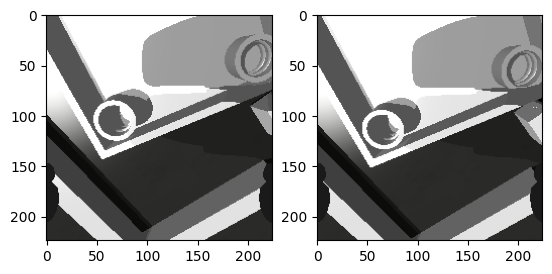

In [4]:
img = data["color_image1"][0:2]

print(img[0, 0, 0:4, :])

fig, (ax1, ax2) = plt.subplots(1, 2)

# Show the images in color
ax1.imshow(img[0])
ax2.imshow(img[1])

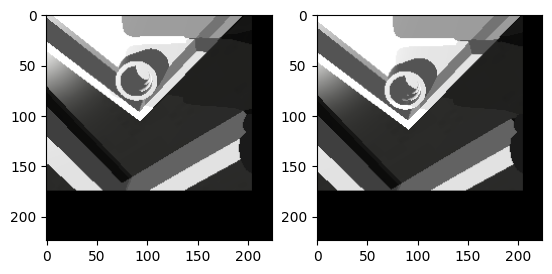

In [ ]:
def random_translate(img):
    max_translation = 50
    H, W, _ = img.shape[1:]
    translated_images = np.zeros_like(img)

    translation_height = np.random.randint(-max_translation, max_translation)
    translation_width = np.random.randint(-max_translation, max_translation)

    # Calculate the indices for zero-padded array
    start_height = max(translation_height, 0)
    end_height = H + min(translation_height, 0)
    start_width = max(translation_width, 0)
    end_width = W + min(translation_width, 0)

    # Calculate the indices for the original image
    start_height_orig = -min(translation_height, 0)
    end_height_orig = H - max(translation_height, 0)
    start_width_orig = -min(translation_width, 0)
    end_width_orig = W - max(translation_width, 0)

    # Index into the zero-padded array and place the original image
    translated_images[:, start_height:end_height, start_width:end_width, :] = img[
        :, start_height_orig:end_height_orig, start_width_orig:end_width_orig, :
    ]

    return translated_images


translated_images = random_translate(img)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(translated_images[0])
ax2.imshow(translated_images[1])

In [18]:
data["episode_ends"][:]

array([ 475,  993, 1441, 1961, 2411, 2890, 3381, 3913, 4379, 4863],
      dtype=uint32)

## Test the augmentation module

In [17]:
from src.dataset.augmentation import ImageAugmentation
from src.dataset.normalizer import StateActionNormalizer

In [13]:
aug = ImageAugmentation(random_translate=True, color_jitter=True, random_rotate=True)

In [14]:
img = data["color_image2"][125]

100%|██████████| 4/4 [00:00<00:00, 50.99it/s]


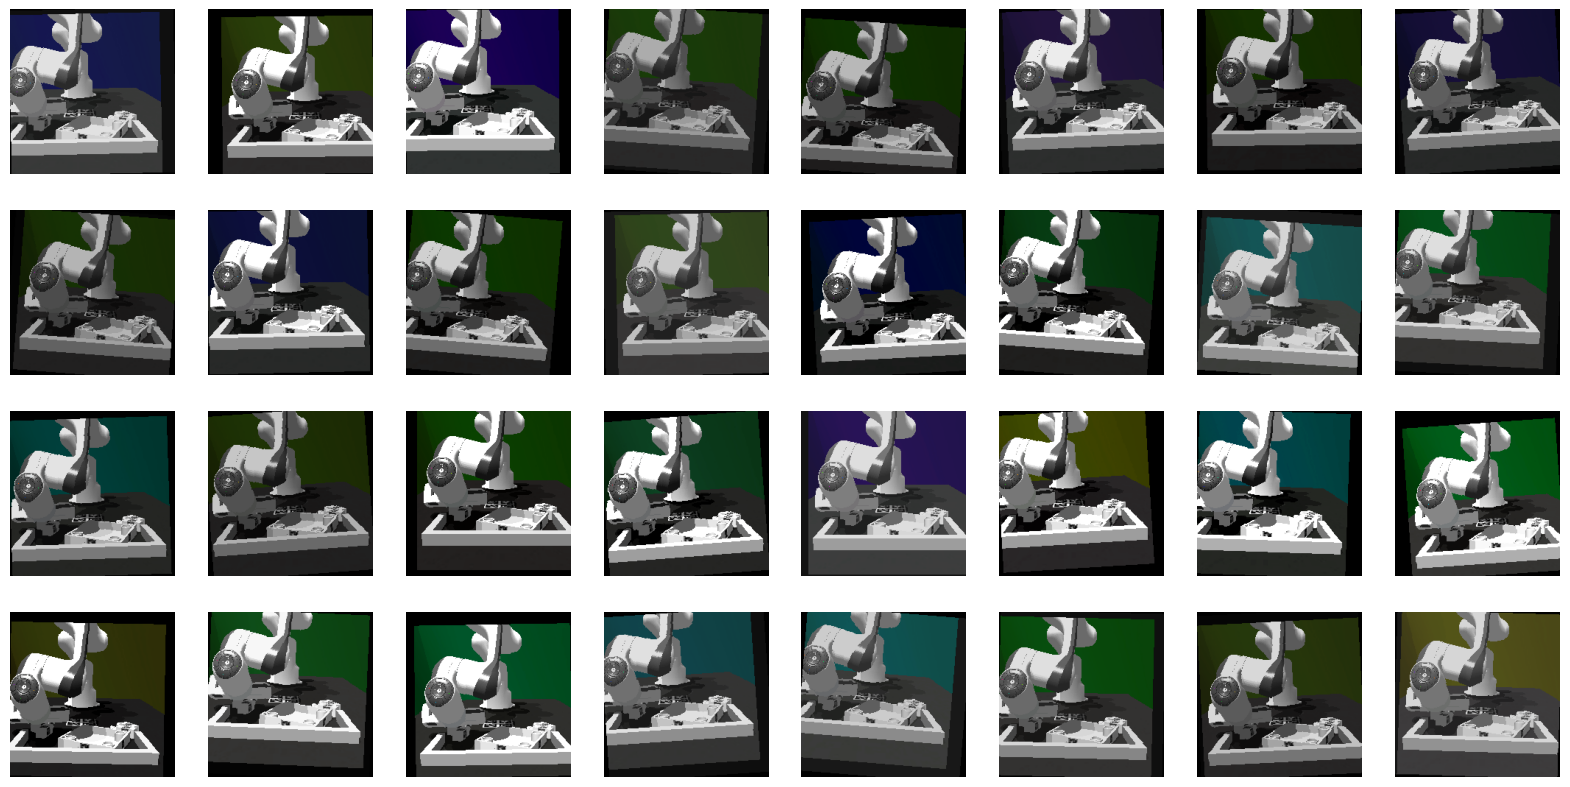

In [15]:
# Make a grid of 4 by 8 images, each with different augmentation
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for i in tqdm(range(4)):
    for j in range(8):
        img_aug = aug(img)
        axes[i, j].imshow(img_aug)
        axes[i, j].axis("off")

In [24]:
# Validate that the augmentation is working in the dataset class
from src.dataset.dataset import FurnitureImageDataset

dataset = FurnitureImageDataset(
    dataset_path=dataset_path,
    action_horizon=8,
    obs_horizon=2,
    pred_horizon=16,
    augment_image=True,
    normalizer=StateActionNormalizer(),
)

Loading dataset of 699 episodes


In [28]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

100%|██████████| 8/8 [00:00<00:00, 969.53it/s]


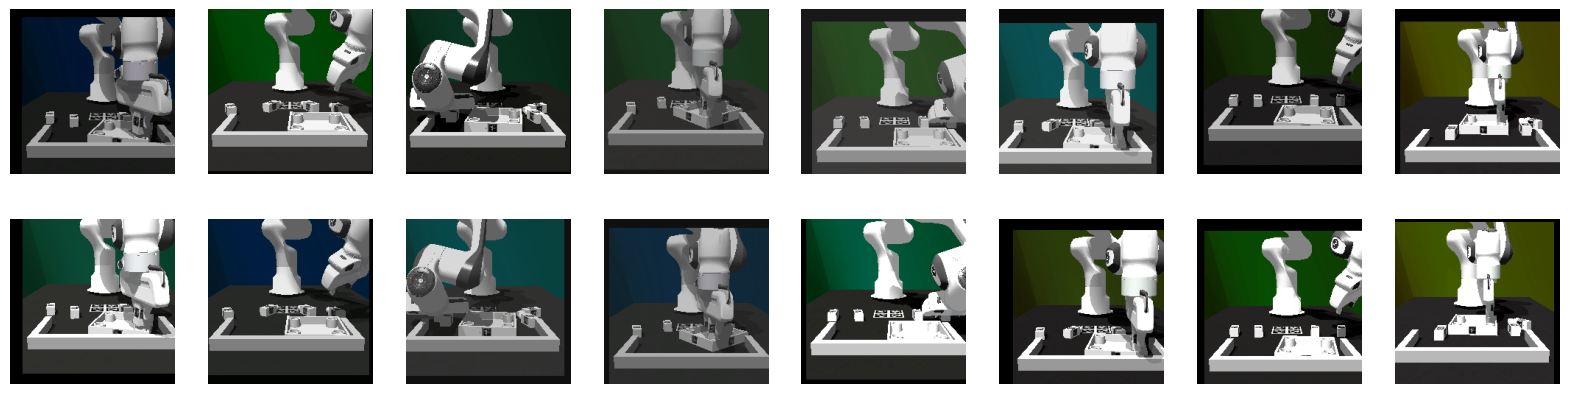

In [33]:
# Get 8 pairs of images and show them
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

batch = next(iter(loader))

for i in tqdm(range(8)):
    axes[0, i].imshow(batch["color_image2"][i][0])
    axes[1, i].imshow(batch["color_image2"][i][1])

    # TUrn off the axes
    axes[0, i].axis("off")
    axes[1, i].axis("off")

## New Image Aug System Test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zarr
from pathlib import Path
import os
from src.common.vision import WristCameraTransform, FrontCameraTransform
import torch
import numpy as np
import torchvision
from torchvision import utils
import matplotlib.pyplot as plt

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. 

In [3]:
data_path ="/data/scratch/ankile/furniture-data/processed/sim/lamp/scripted/low/success.zarr"

z = zarr.open(
    data_path,
    mode="r",
)

In [22]:
# Get some images
images = torch.from_numpy(z["color_image2"][0:100])

In [23]:
# Pass them through the transform
transform = FrontCameraTransform()
transformed_images = transform(images.permute(0, 3, 1, 2))

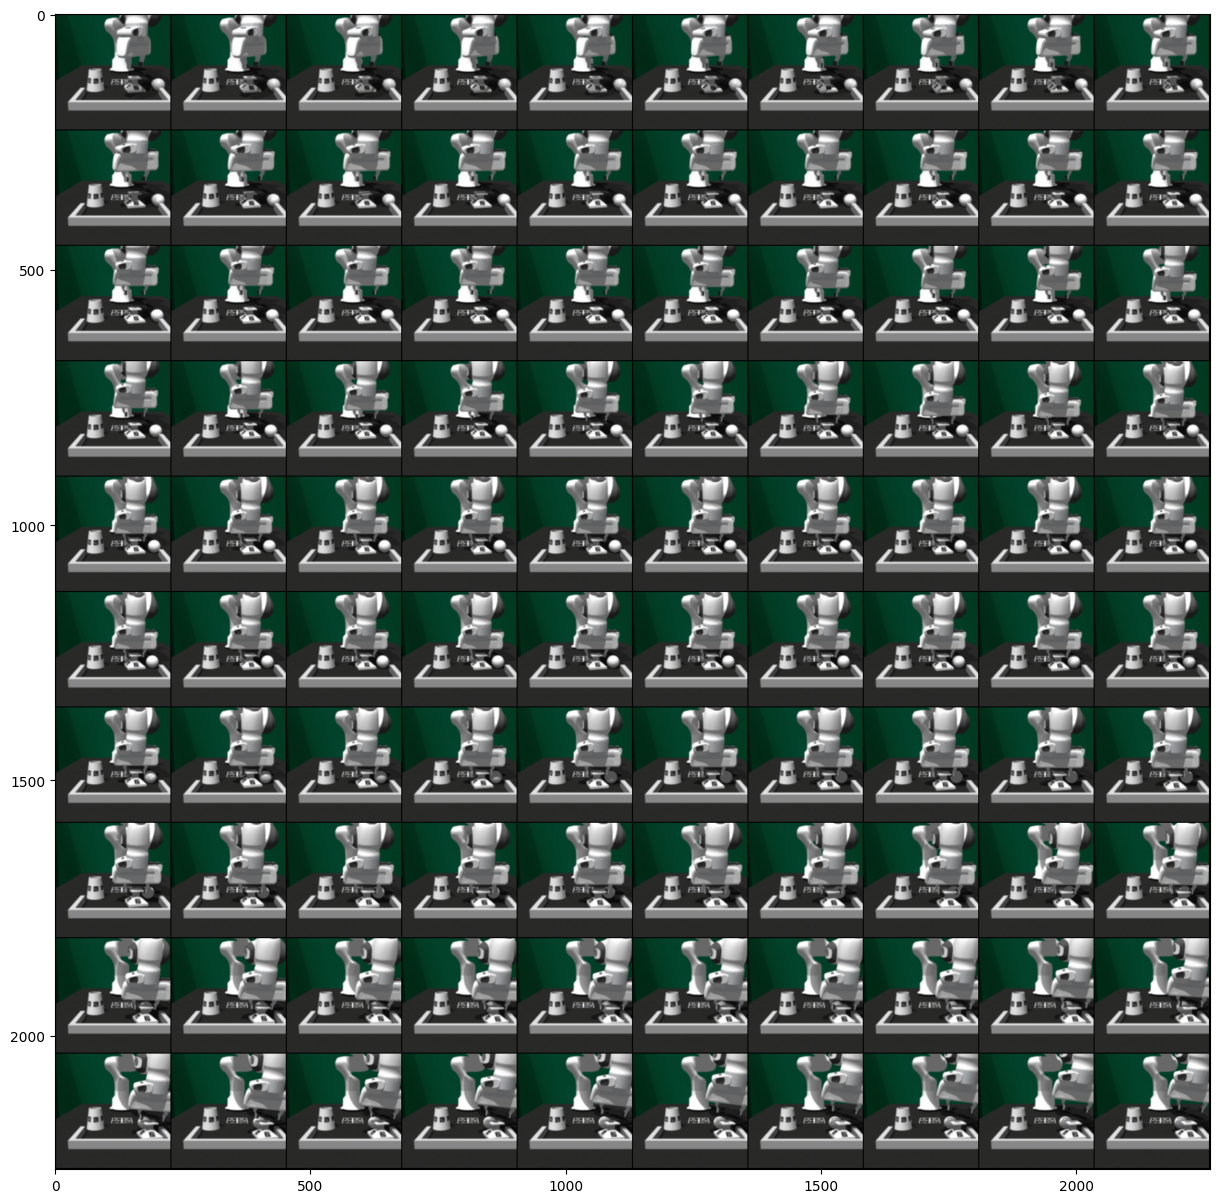

In [24]:
# Show a torchvision grid of the images
grid = utils.make_grid(transformed_images, nrow=10)
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0))


In [91]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from src.dataset.dataset import FurnitureImageDataset


dataset = FurnitureImageDataset(
    dataset_paths=data_path,
    pred_horizon=16,
    obs_horizon=2,
    action_horizon=8,
    augment_image=True,
    data_subset=10,
)

# Split the dataset into train and test
train_size = int(len(dataset) * (1 - 0.1))
test_size = len(dataset) - train_size
print(f"Splitting dataset into {train_size} train and {test_size} test samples.")
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create data loaders with different transformations
batch_size = 32
shuffle_train = True  # Set to True for training data loader
shuffle_val = False  # Set to False for validation data loader

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train, num_workers=4, pin_memory=True, drop_last=True)
val_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_val, num_workers=4, pin_memory=True, drop_last=True)

Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]



























Loading zarr files: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


Loading dataset of 10 episodes
Splitting dataset into 8487 train and 943 test samples.


In [94]:
# train_data_loader.dataset.dataset.image2_transform.mode = "eval"
batch = next(iter(train_data_loader))

imgs = batch["color_image2"].reshape(-1, 224, 224, 3).permute(0, 3, 1, 2)

imgs.shape

torch.Size([64, 3, 224, 224])

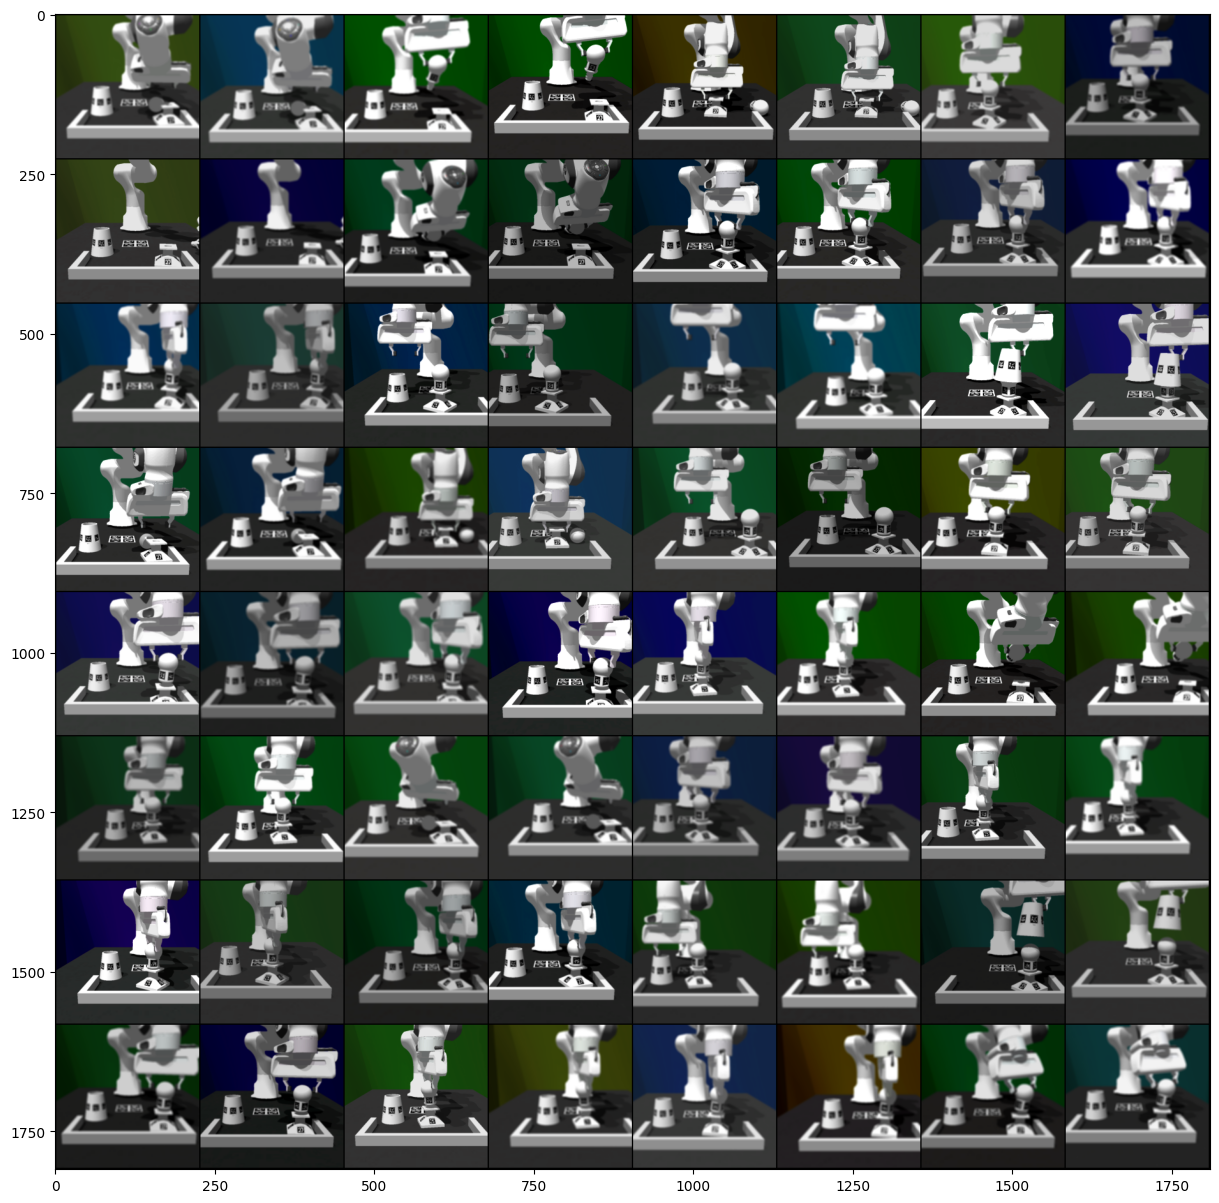

In [93]:
# Show a grid of images
grid = utils.make_grid(imgs, nrow=8)

plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0))

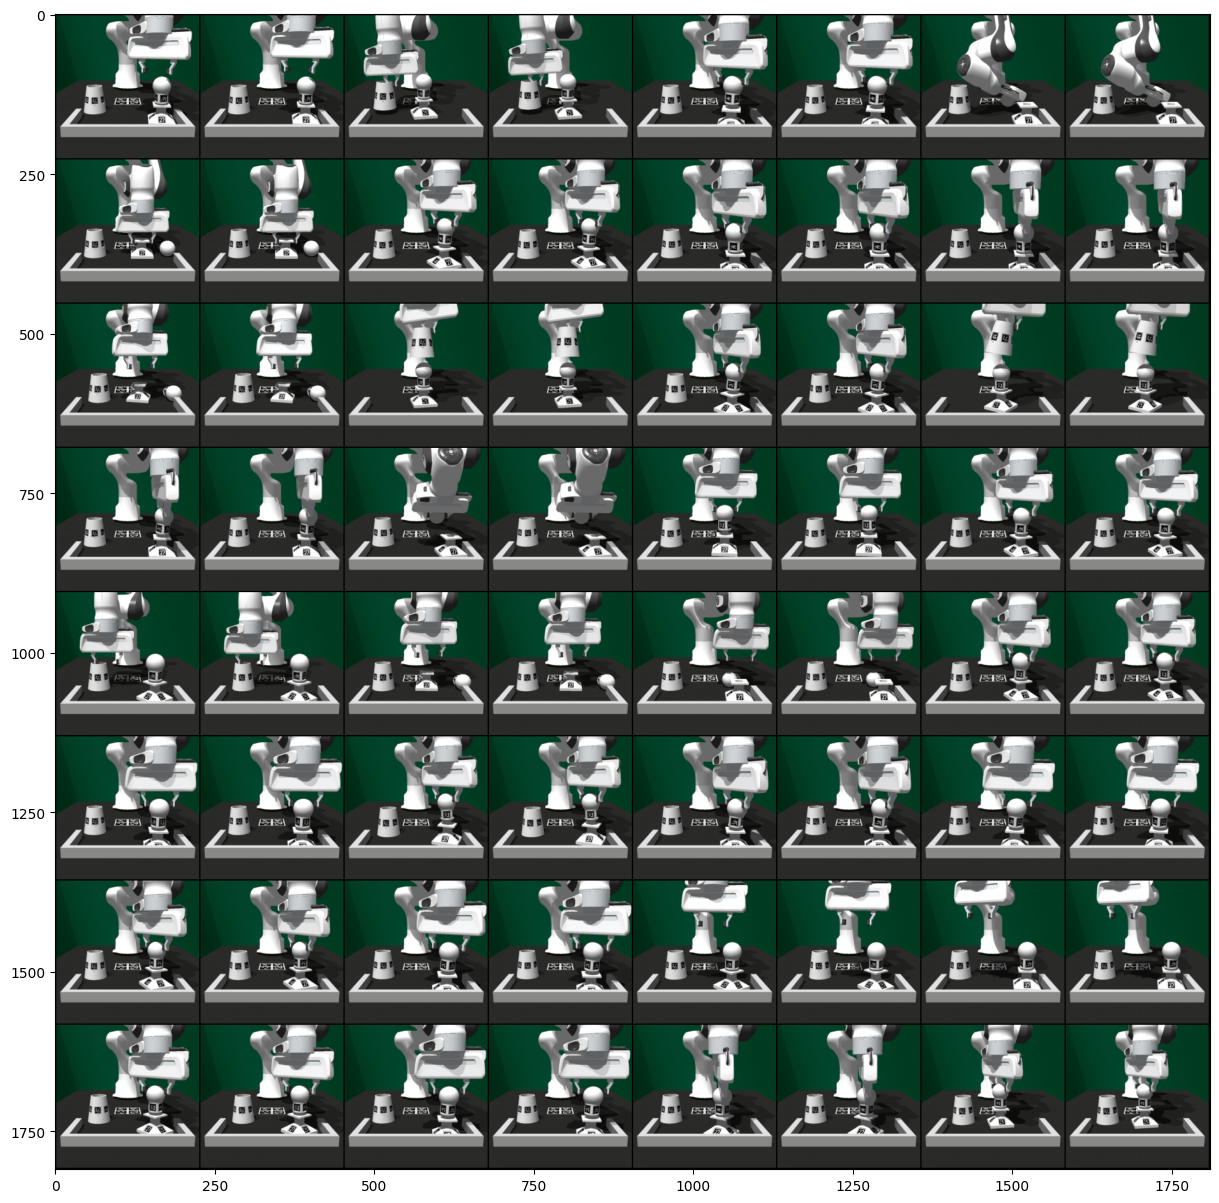

In [95]:
# Sample a batch from the train data loader
train_data_loader.dataset.dataset.eval()

# train_data_loader.dataset.dataset.image2_transform.mode = "eval"
batch = next(iter(train_data_loader))

imgs = batch["color_image2"].reshape(-1, 224, 224, 3).permute(0, 3, 1, 2)

# Show a grid of images
grid = utils.make_grid(imgs, nrow=8)

plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0))

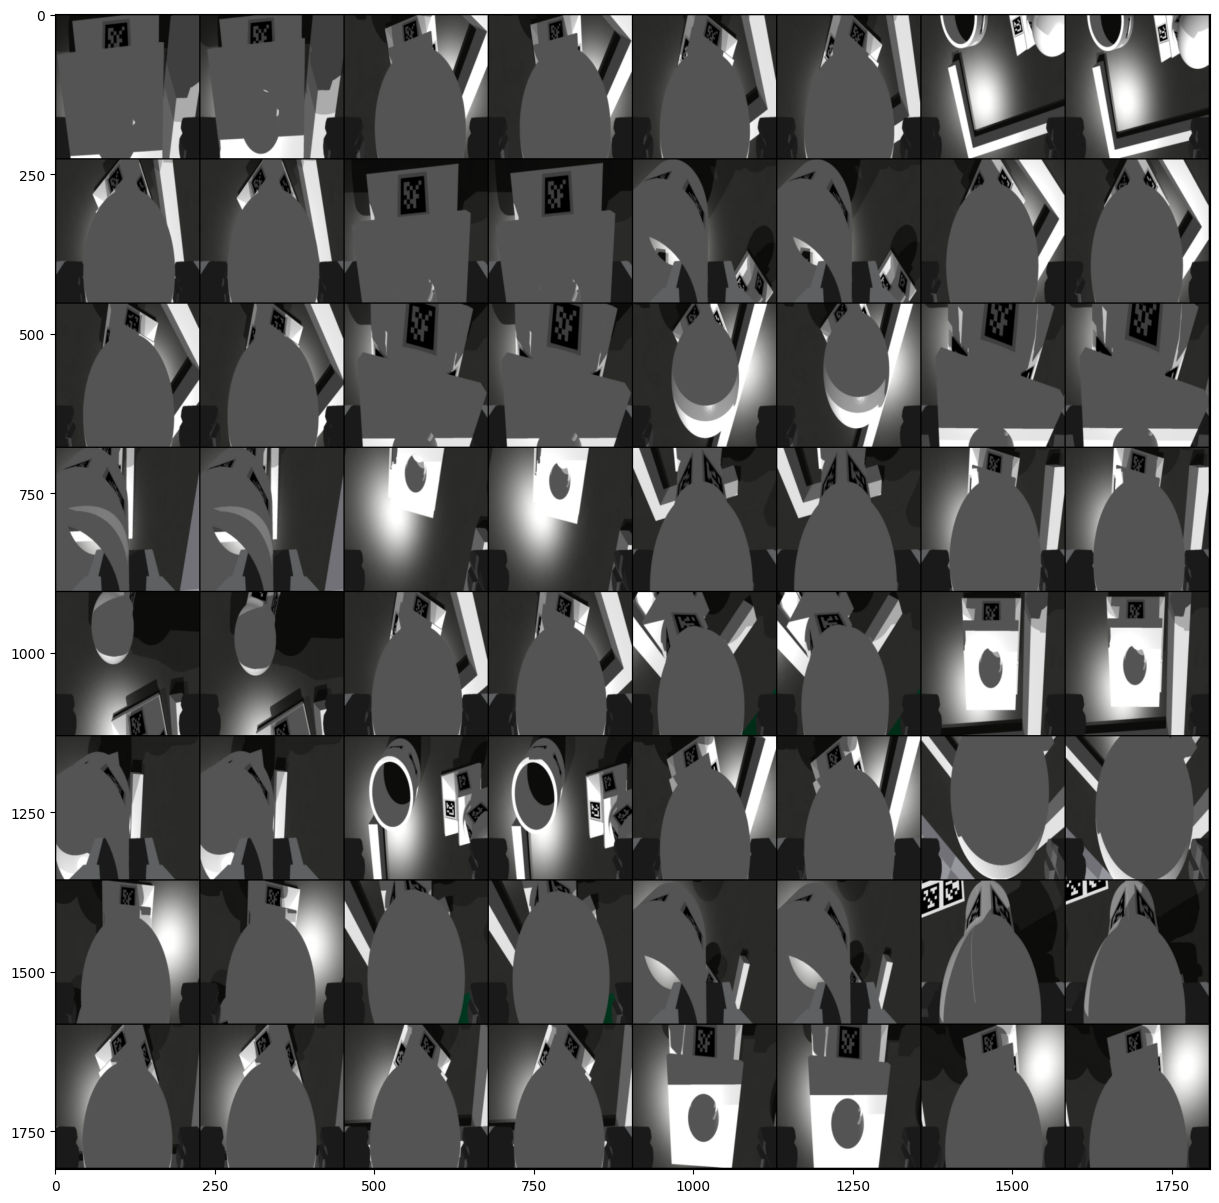

In [97]:
# train_data_loader.dataset.dataset.image2_transform.mode = "eval"
batch = next(iter(train_data_loader))

imgs1 = batch["color_image1"].reshape(-1, 224, 224, 3).permute(0, 3, 1, 2)

# Show a grid of images
grid = utils.make_grid(imgs1, nrow=8)

plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0))

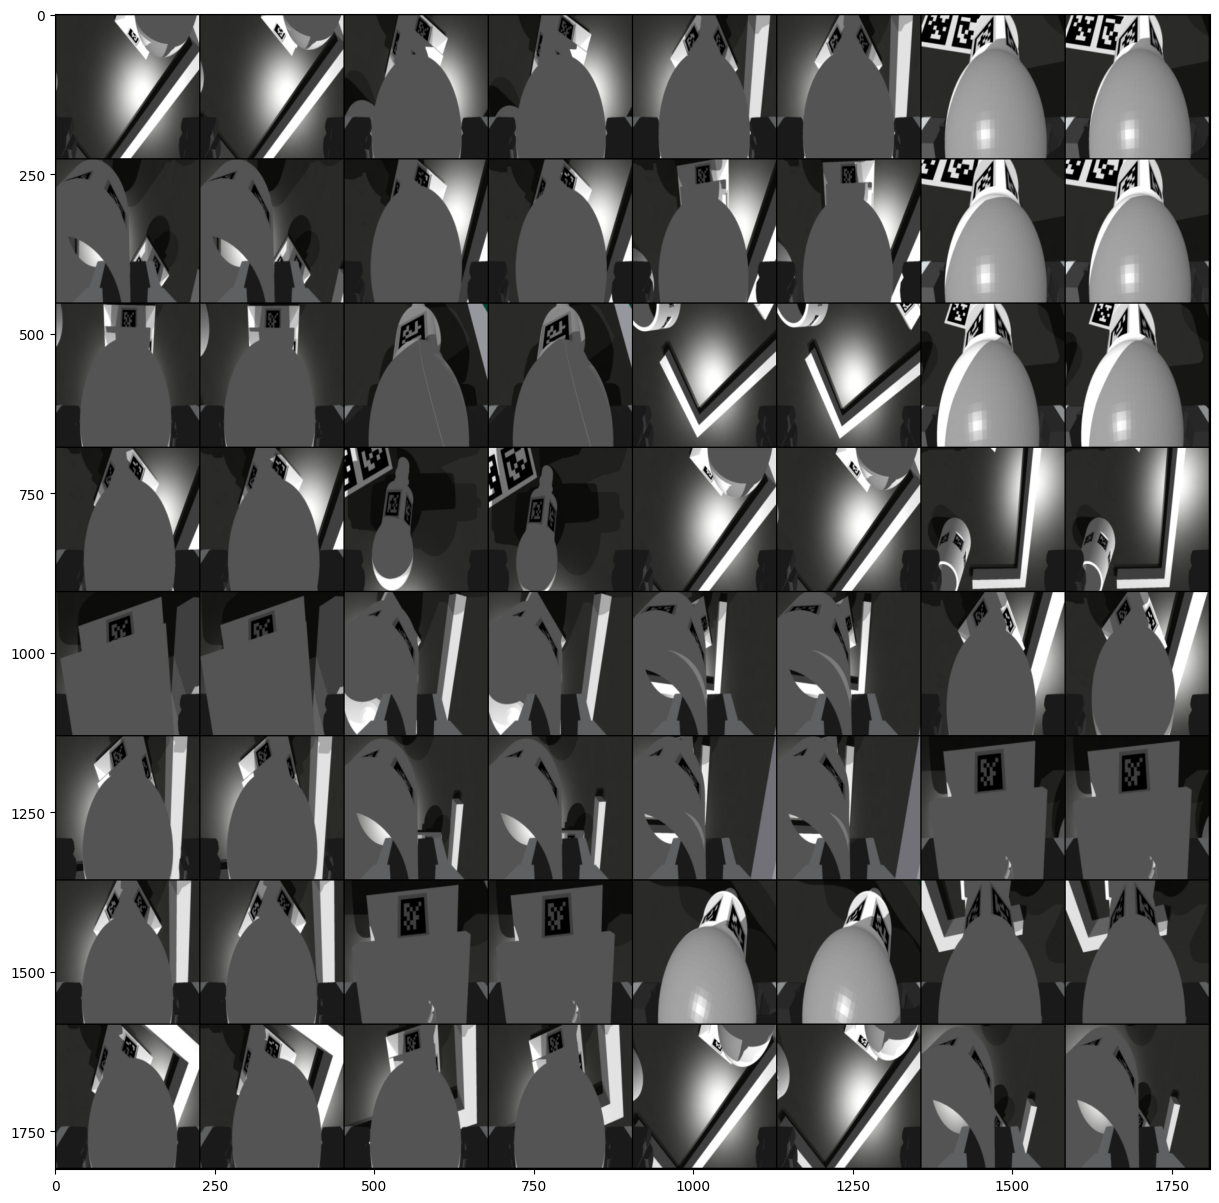

In [98]:
# Sample a batch from the train data loader
train_data_loader.dataset.dataset.eval()

batch = next(iter(train_data_loader))

imgs1 = batch["color_image1"].reshape(-1, 224, 224, 3).permute(0, 3, 1, 2)

# Show a grid of images
grid = utils.make_grid(imgs1, nrow=8)

plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0))